In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression

sns.set()

In [13]:
titanic = pd.read_csv("train.csv")
gender = pd.read_csv("gender_submission.csv")

In [56]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
titanic.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


/home/linuser/data/utils/python/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/linuser/data/utils/python/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


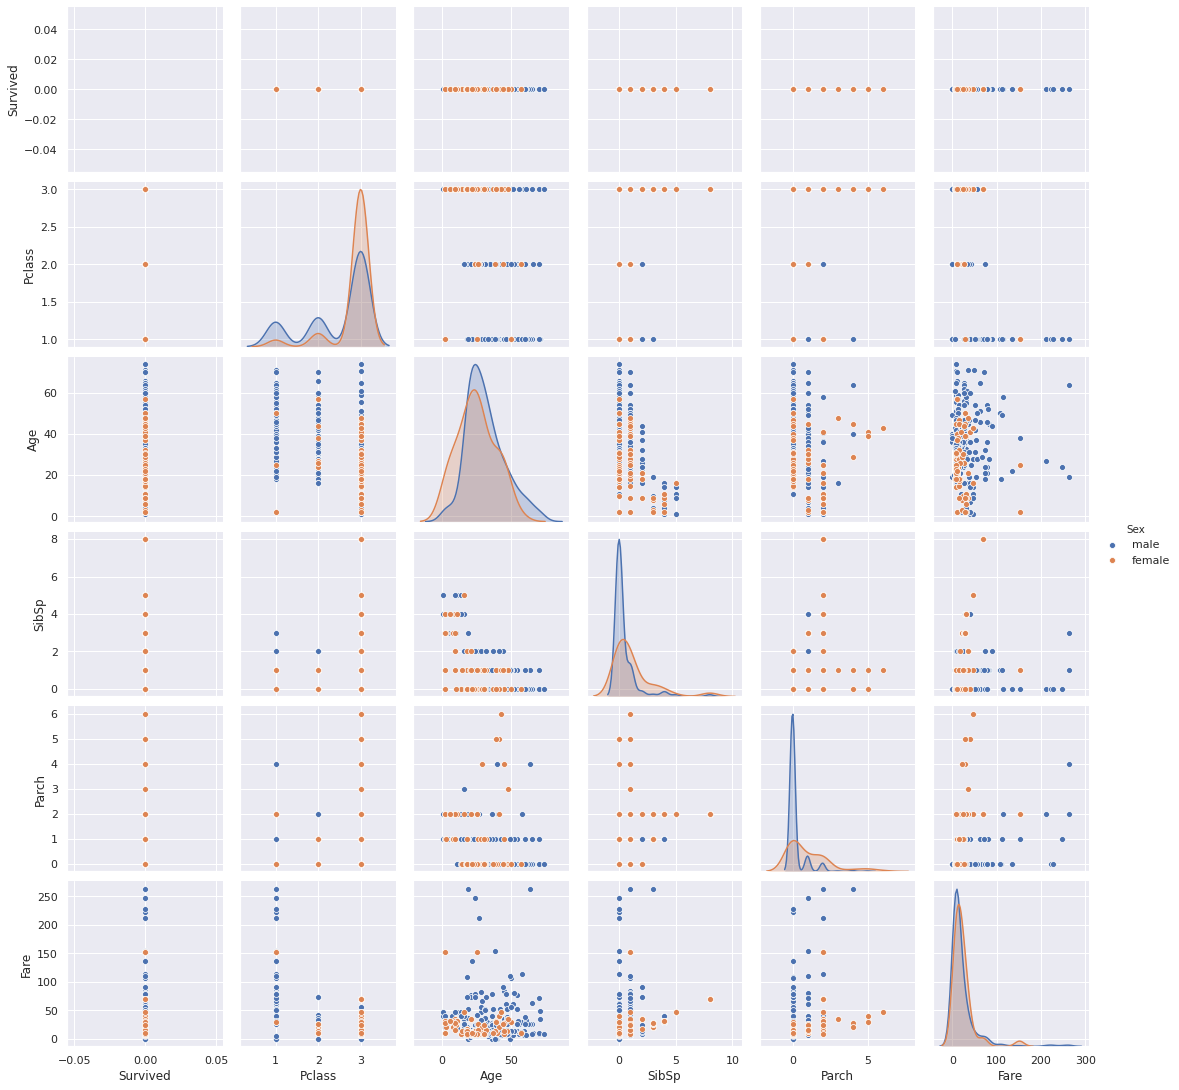

In [65]:
#sns.pairplot(data=titanic, x_vars=["Pclass", "Fare", "Parch"], y_vars = ["Pclass", "Fare", "Parch"], hue="Survived", aspect=1.2, height=3)
sns.pairplot(titanic[titanic.Survived == 0], hue="Sex")

/home/linuser/data/utils/python/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/linuser/data/utils/python/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


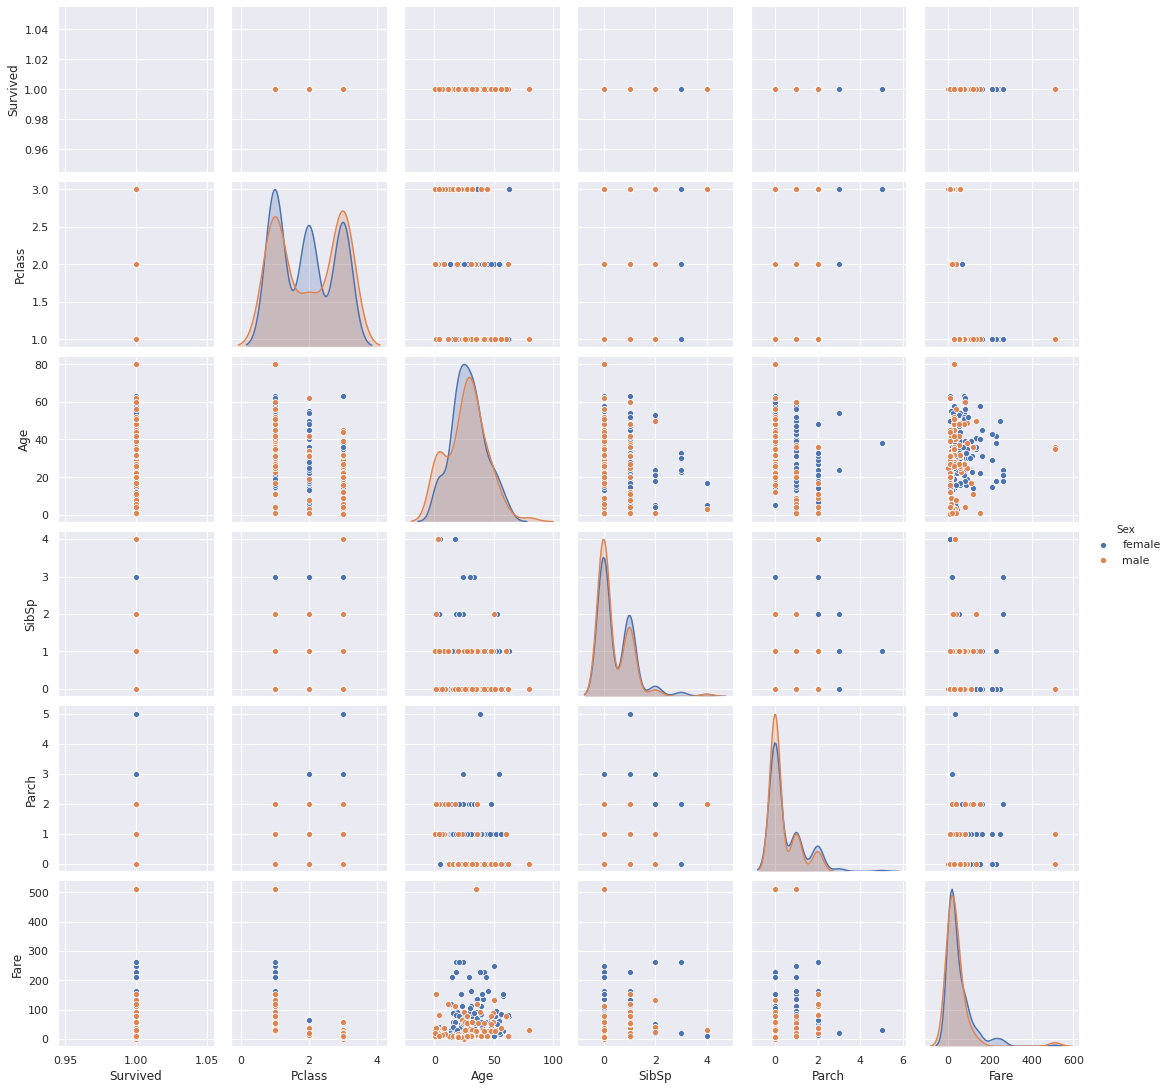

In [86]:
sns.pairplot(titanic[titanic.Survived == 1], hue="Sex")

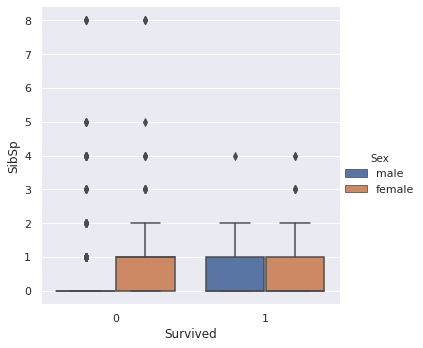

In [81]:
sns.catplot(data=titanic, x="Survived", y="SibSp", hue="Sex", kind="box")

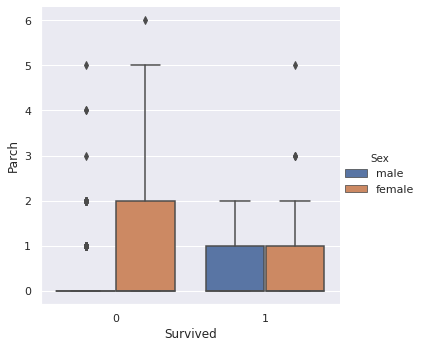

In [83]:
sns.catplot(data=titanic, x="Survived", y="Parch", hue="Sex", kind="box")

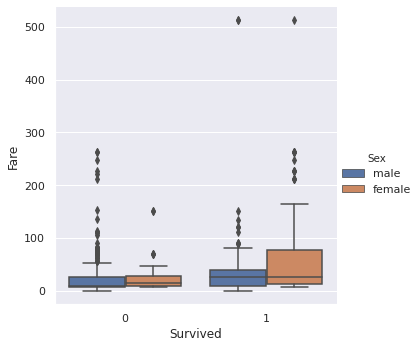

In [84]:
sns.catplot(data=titanic, x="Survived", y="Fare", hue="Sex", kind="box")